目标检测:
实际运用中, 图片分类用得没那么多, 我们更常运用的是如何识别图片中的各种东西, 也就是目标检测
目标检测的重要工具:边缘框

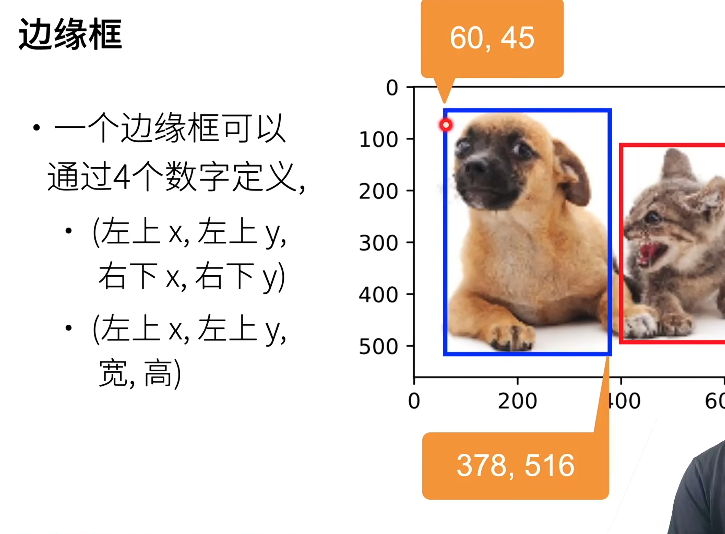

目标检测数据集
一个图片中可能有多个类, 所以存起来比图片分类更加复杂
常用的一个方法是一行表示一个图片中的一个物体:图片文件名+物体类别+边缘框

In [ ]:
# 边缘框的实现
%matplotlib inline
import torch
from d2l import torch as d2l

d2l.set_figsize()
img = d2l.plt.imread('../img/catdog.jpg')
d2l.plt.imshow(img);

In [ ]:
# 框图有多种表示方法, 这里定义了两个表示方法之间切换的函数
def box_corner_to_center(boxes):
    """从（左上，右下）转换到（中间，宽度，高度）"""
    x1, y1, x2, y2 = boxes[:, 0], boxes[:, 1], boxes[:, 2], boxes[:, 3]
    cx = (x1 + x2) / 2
    cy = (y1 + y2) / 2
    w = x2 - x1
    h = y2 - y1
    boxes = torch.stack((cx, cy, w, h), axis=-1)
    return boxes

def box_center_to_corner(boxes):
    """从（中间，宽度，高度）转换到（左上，右下）"""
    cx, cy, w, h = boxes[:, 0], boxes[:, 1], boxes[:, 2], boxes[:, 3]
    x1 = cx - 0.5 * w
    y1 = cy - 0.5 * h
    x2 = cx + 0.5 * w
    y2 = cy + 0.5 * h
    boxes = torch.stack((x1, y1, x2, y2), axis=-1)
    return boxes

In [ ]:
# 这里输入框的数据
dog_bbox, cat_bbox = [60.0, 45.0, 378.0, 516.0], [400.0, 112.0, 655.0, 493.0]

boxes = torch.tensor((dog_bbox, cat_bbox))
box_center_to_corner(box_corner_to_center(boxes)) == boxes

In [ ]:
根据数据画框
def bbox_to_rect(bbox, color):
    return d2l.plt.Rectangle(xy=(bbox[0], bbox[1]), width=bbox[2] - bbox[0],
                             height=bbox[3] - bbox[1], fill=False,
                             edgecolor=color, linewidth=2)

fig = d2l.plt.imshow(img)
fig.axes.add_patch(bbox_to_rect(dog_bbox, 'blue'))
fig.axes.add_patch(bbox_to_rect(cat_bbox, 'red'));

锚框
有很多目标识别的算法都是基于锚框的, 那么锚框是一个什么样的操作呢:
- 提出多个被称为锚框的区域, 它们以边缘框的形式出现
- 预测每个锚框中是否包含我们关注的物体
- 如果是, 预测这个框到真实物体框之间的偏移

交并比(IoU): 我们如何比较两个框之间的相似度, 字面意思, 就是交/并                                
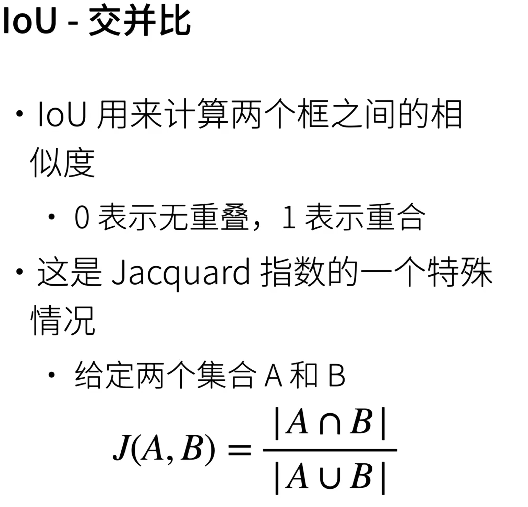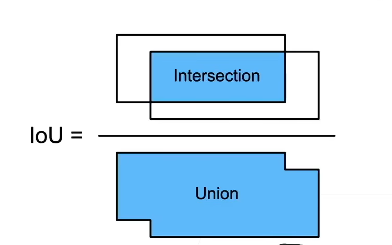

赋予锚框编号:
我们生成很多个锚框, 每一个锚框都是一个训练样本, 每一个锚框生成时要不就标注成背景(只有背景), 要不就和一个真实的边缘框相关联
由于生成了很多锚框, 这样会有大量的负类样本(只有背景的锚框)

现在我们获取到了物体原本的边缘框和我们自己生成的很多个锚框, 形成了下面这个矩阵, 这个矩阵由IoU值组成, 边缘框对应列, 锚框对应行, 我们可以找到IoU的最大值, 将边缘框和锚框匹配, 直到所有边缘框都至少找到一个锚框关联起来

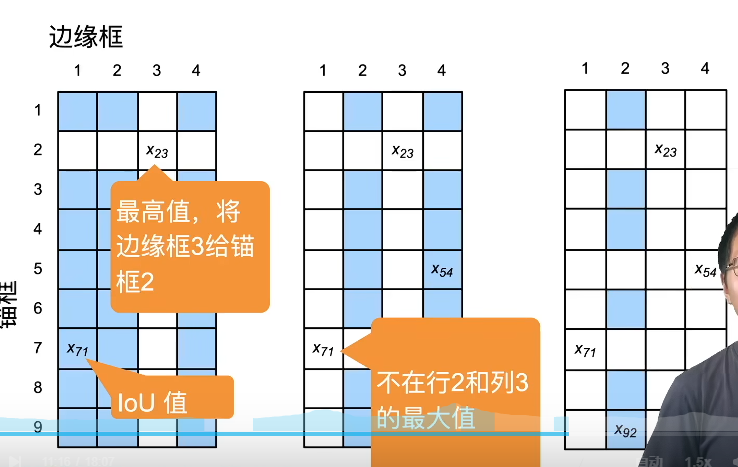

用非极大值抑制输出(NMS)
现在我们来到预测的阶段, 有时候我们预测锚框时, 结果会是一个边缘框对应了多个锚框, 我们希望最终能得到一个干净的输出, 一个锚框对应一个边缘框
- 首先, 选择非背景类的最大预测值
- 然后去掉所以IoU值大于θ的预测
- 重复直到所有预测被选中或被去掉

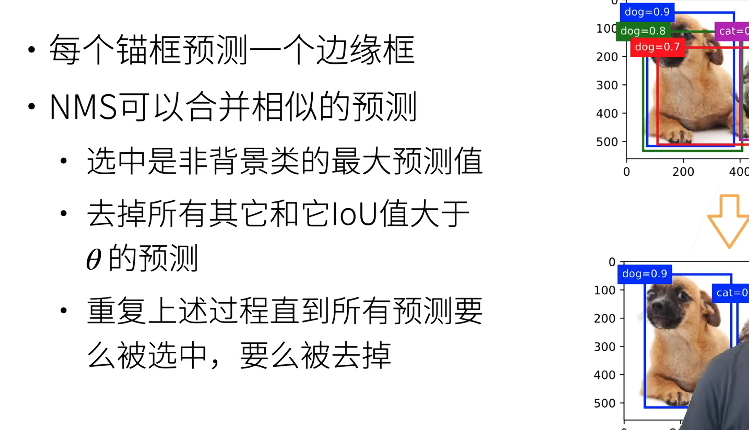

代码实现:略
- 每个像素生成不同大小的锚框, 获取很多个锚框
- IoU计算函数
- 最大IoU分析, 选取合适的锚框
- 通过锚框位置和边缘框位置获得偏移量

物体检测算法速过
基于区域的CNN(R-CNN)
使用启发式搜索算法来选择锚框
使用预训练模型来对每个锚框抽取特征
针对类别训练一个支持者
训练一个线性回归模型来预测边缘框偏移

锚框有大有小, 如何确定对不同大小的锚框进行分析呢:
兴趣区域池化层(RoI)
给定一个锚框(可重复的)均匀分成n*m块, 输出每块的最大值
这样的话, 不管给出多大的锚框,最后都变成了n*m的输出, 这样就可以一起进行分析了
比如, 下图就将一个3*3的锚框分解成了2*2块

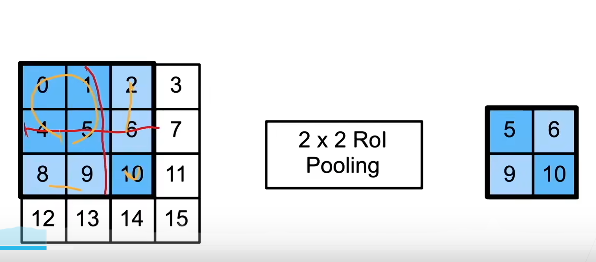

1.候选区域生成: 输入一张图像, 使用 ​选择性搜索（Selective Search）或者RPN(见下图)​​ 生成约 2000 个候选区域, 最终输出多个可能包含目标的边界框
2.特征提取:将每个候选区域 ​裁剪并缩放到固定大小​（如 227×227），输入预训练的 CNN（如AlexNet）提取特征
3.对每个候选区域的特征，训练一个 ​SVM 分类器​ 判断类别（如猫、狗、背景）, 输出候选框的标签
4.使用线性回归模型微调候选框的位置，使其更贴合目标, 输出微调后的边界框

FAST RCNN
不再对锚框抽取特征, 而是对整个图片抽取特征
FASTER RCNN
相当于优化了锚框步骤, 在锚框之前又使用了一次粗略的锚框(里面是一个二分预测, 预测这个锚框是不是"优秀的"锚框)

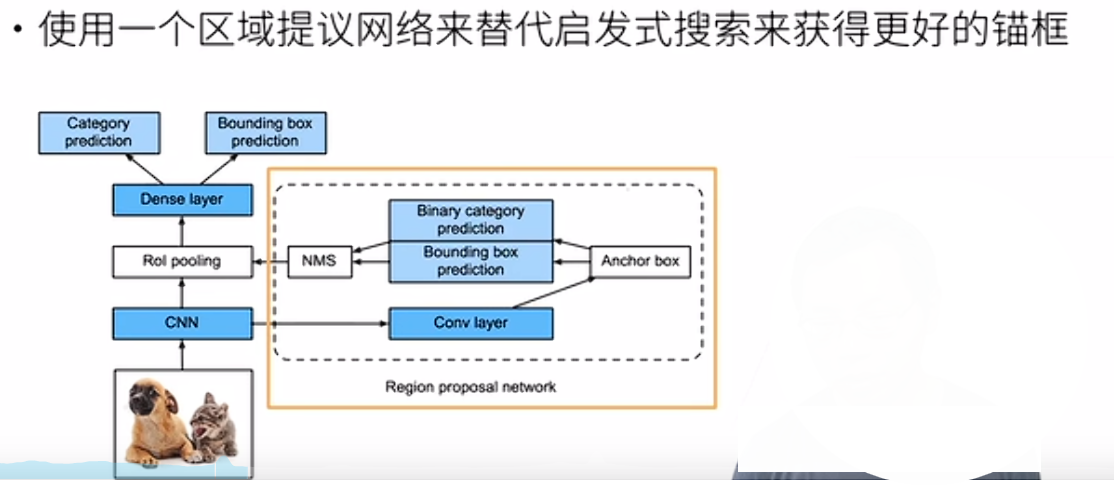

MUSK R-CNN: 可以利用像素级别的标号
fast rcnn:追求高精度的时候使用, 它精度高, 但是计算冗余较大, 速度慢

单发多框检测(SSD)
SSD（Single Shot MultiBox Detector）是一种 ​单阶段（Single Shot）​​ 目标检测算法
SSD可以​直接预测目标的类别和位置，无需生成候选区域
1.多尺度特征图:后面会讲到
2.在每个特征图的每个位置预设 ​不同比例和大小​ 的默认框（类似锚框）, 作为预测的参考基准
3.分类分支​：对每个默认框预测类别得分;  回归分支​：预测边界框的偏移量
4.使用 ​非极大值抑制（NMS）​​ 过滤冗余框，保留最可能的检测结果, 输出最终的目标类别和边界框

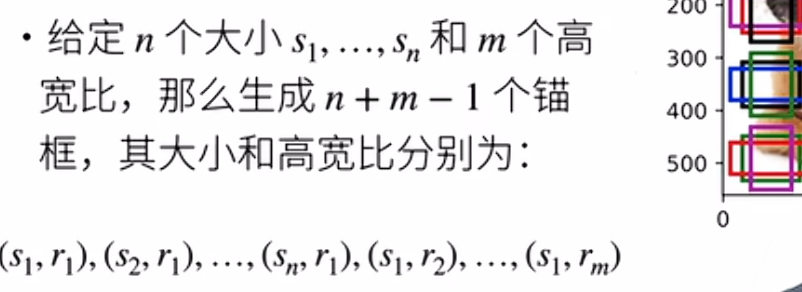

SSD 的 "Single Shot" 体现在哪里？​​
SSD 的 ​​"Single Shot"​​ 是指 ​只需一次前向传播即可完成检测，也就是说RNN是得先列出许多可能的选择, 在选取最合适的,两步;而SSD直接一步到位了

​​(1) 直接预测​
​R-CNN​：需要先生成候选区域，再对每个区域分类和回归（两阶段）。
​SSD​：在特征图上直接预测类别和边界框偏移量（单阶段）。
​​(2) 无候选区域生成​
​R-CNN​：依赖选择性搜索或 RPN（如Faster R-CNN）生成候选框。
​SSD​：通过预设的默认框（Anchors）覆盖所有可能的目标位置，直接预测。
​​(3) 高效的单次计算​
​R-CNN​：对每个候选区域独立计算特征，重复计算多。
​SSD​：共享基础网络的特征图，一次前向传播完成所有预测。

YOLO
ssd中锚框重叠太多了, 十分浪费计算力, YOLO尽量不让锚框重叠
YOLO将图片分为S*S个锚框, 每个锚框预测B个边缘框(防止分区时一个锚框中有多个物体), 如下图, 锚框没有重叠

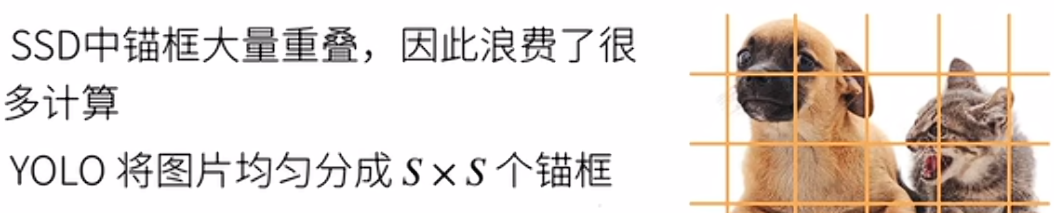